Loading dataset into DataFrame...

🔹 Next-day total prediction results:
RandomForest MAE: 4.365754759463709
RandomForest RMSE: 6.0018119110332195
XGBoost MAE: 4.899808158115258
XGBoost RMSE: 6.550676589294504


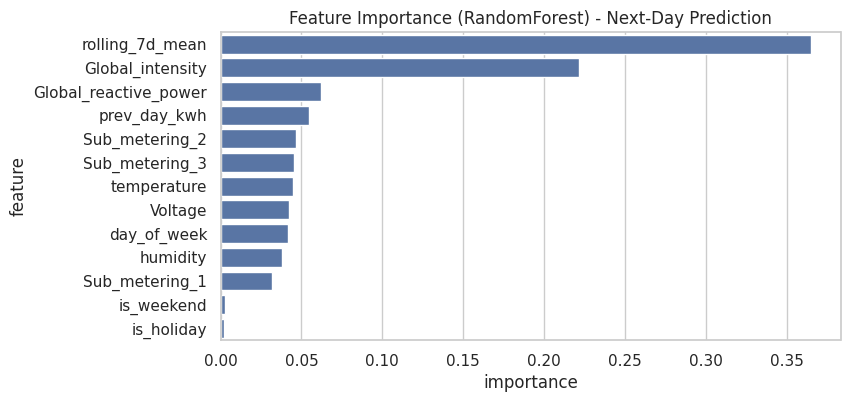

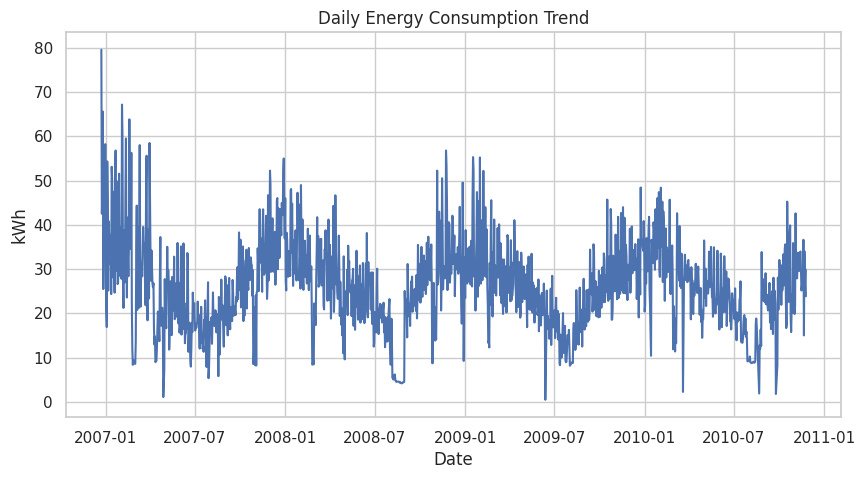


Predicted next-day total (RF) for next date after 2010-11-25 → 27.61 kWh
Slightly above average — monitor evening usage, postpone washing cycles if possible.

⚡ Estimated Energy Cost Analysis for Tomorrow ⚡
Predicted Total Energy: 27.61 kWh
Estimated Total Cost: ₹82.84
💡 Suggested Optimal Appliance Usage Hour: 2:00 hrs (cheapest period)
Minimum Hourly Cost: ₹1.38


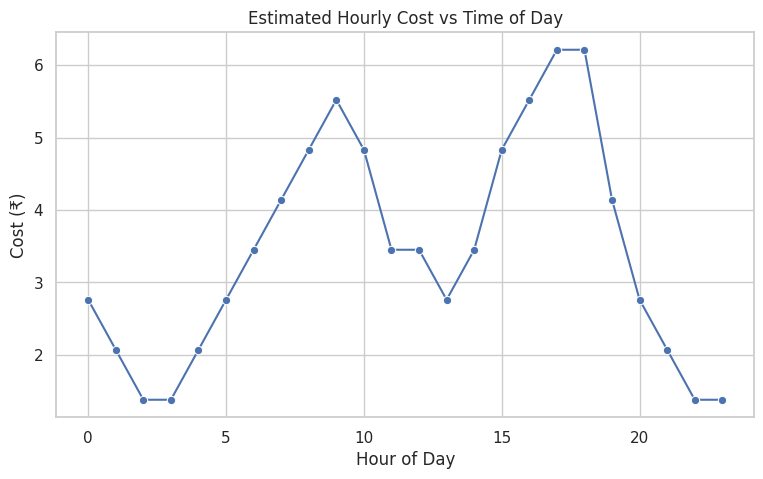

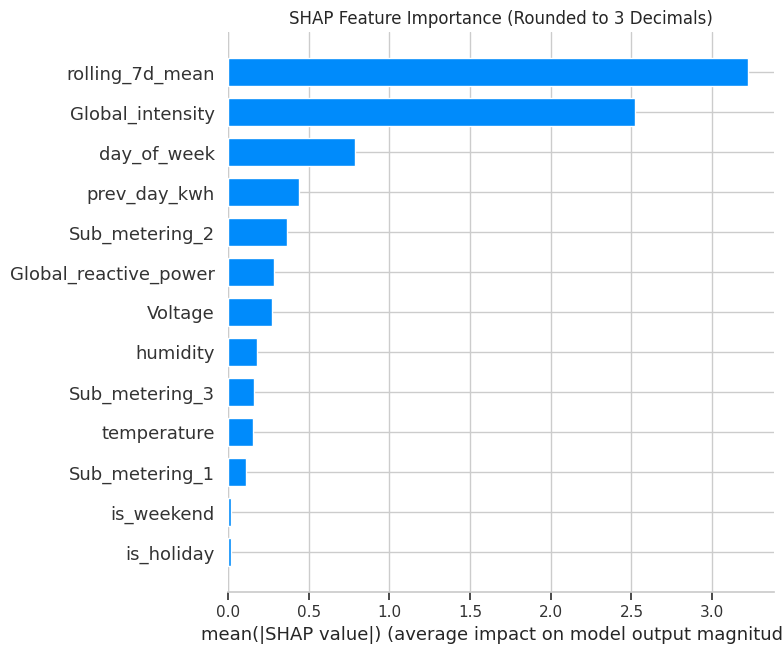

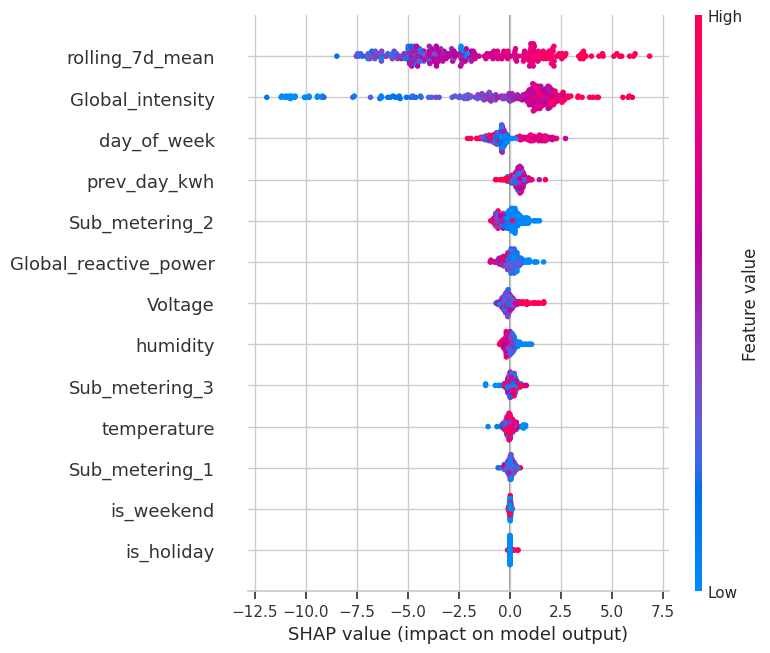

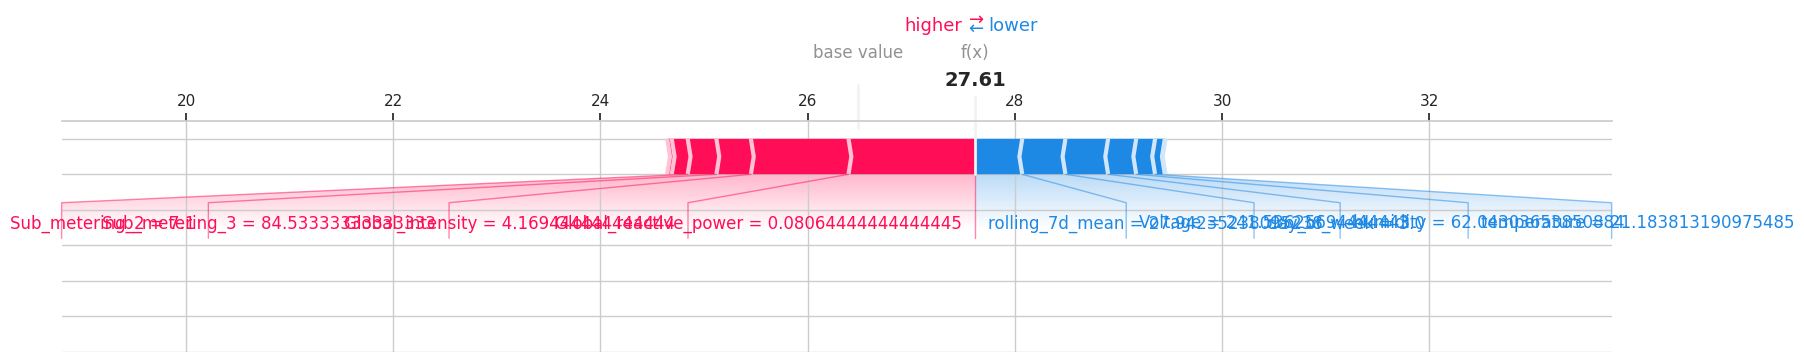


✅ SHAP feature importance exported to 'shap_feature_importance.csv'


,Feature,Mean_SHAP_Importance
1,rolling_7d_mean,3.222649
4,Global_intensity,2.523811
8,day_of_week,0.785074
0,prev_day_kwh,0.436944
6,Sub_metering_2,0.363333
2,Global_reactive_power,0.281740
3,Voltage,0.273796
10,humidity,0.177849
7,Sub_metering_3,0.162923
9,temperature,0.152933



🌍 Sustainability Impact Report:
Predicted next-day energy: 27.61 kWh
Predicted CO₂ emissions: 22.64 kg CO₂
If 10% reduction achieved → Save 2.26 kg CO₂


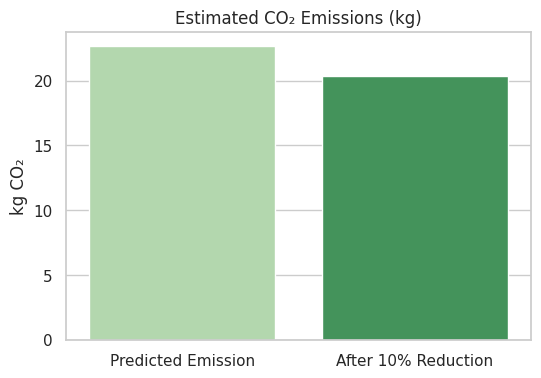


✅ Notebook finished: Next-Day Energy Consumption Predictor ready.


In [ ]:
# ================================================================
# 🌍 AI-Based Energy Consumption Predictor (Next-Day Forecast Only)
# Dataset: UCI Individual household electric power consumption
# Goal: Predict total daily energy consumption for the next day
# ================================================================

!pip install -q xgboost joblib holidays requests

import os, zipfile, io, warnings, requests, holidays
from urllib.request import urlopen
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

# === Step 1: Download & Load Dataset ===
zip_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip'
print('Downloading dataset...')
resp = urlopen(zip_url).read()
with open('household_power_consumption.zip','wb') as f:
    f.write(resp)

with zipfile.ZipFile('household_power_consumption.zip','r') as z:
    z.extractall()

print('Loading dataset into DataFrame...')
raw = pd.read_csv(
    'household_power_consumption.txt',
    sep=';',
    na_values=['?'],
    low_memory=False
)

# === Step 2: Clean and preprocess (updated for new pandas) ===
raw['datetime'] = pd.to_datetime(raw['Date'] + ' ' + raw['Time'],
                                 dayfirst=True, errors='coerce')

cols = ['Global_active_power','Global_reactive_power','Voltage',
        'Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']
for c in cols:
    raw[c] = pd.to_numeric(raw[c], errors='coerce')

raw = raw.dropna(subset=['datetime'])
raw = raw.sort_values('datetime').reset_index(drop=True)
raw = raw.set_index('datetime')

# Hourly & Daily Aggregation
hourly = raw[cols].resample('h').mean().dropna().reset_index()
hourly['date'] = hourly['datetime'].dt.date

daily = hourly.groupby('date').agg({
    'Global_active_power':'sum',  # total daily usage in kWh
    'Global_reactive_power':'mean',
    'Voltage':'mean',
    'Global_intensity':'mean',
    'Sub_metering_1':'sum',
    'Sub_metering_2':'sum',
    'Sub_metering_3':'sum'
}).rename(columns={'Global_active_power':'daily_kwh'}).reset_index()

# Add lag and rolling features
daily['prev_day_kwh'] = daily['daily_kwh'].shift(1)
daily['rolling_7d_mean'] = daily['daily_kwh'].rolling(7).mean().shift(1)

# === Step: Add external context (Weather + Holiday) ===
np.random.seed(42)

# --- Weather simulation (replace with live API if desired) ---
# Example for real API:
# API_KEY = "YOUR_API_KEY"
# CITY = "Delhi"
# def fetch_weather():
#     url = f"https://api.openweathermap.org/data/2.5/weather?q={CITY}&appid={API_KEY}&units=metric"
#     data = requests.get(url).json()
#     return data['main']['temp'], data['main']['humidity']

daily['temperature'] = 25 + np.sin(np.arange(len(daily))/30)*10 + np.random.normal(0,2,len(daily))
daily['humidity'] = 60 + np.random.normal(0,5,len(daily))

# --- Holiday & Weekend flags ---
india_holidays = holidays.India(years=range(2006,2011))
daily['is_holiday'] = daily['date'].apply(lambda d: 1 if d in india_holidays else 0)
daily['is_weekend'] = pd.to_datetime(daily['date']).dt.dayofweek.isin([5,6]).astype(int)

# Day of week & target
daily['day_of_week'] = pd.to_datetime(daily['date']).dt.dayofweek
daily['target_next_day_kwh'] = daily['daily_kwh'].shift(-1)
daily = daily.dropna().reset_index(drop=True)

# === Step 3: Model Training ===
features = [
    'prev_day_kwh','rolling_7d_mean','Global_reactive_power','Voltage',
    'Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3',
    'day_of_week','temperature','humidity','is_holiday','is_weekend'
]
X = daily[features]
y = daily['target_next_day_kwh']

# Time-based split
split_idx = int(len(X)*0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train models
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

xgb = XGBRegressor(n_estimators=300, random_state=42, verbosity=0)
xgb.fit(X_train_scaled, y_train)

# === Step 4: Evaluate ===
pred_rf = rf.predict(X_test)
pred_xgb = xgb.predict(X_test_scaled)

print('\n🔹 Next-day total prediction results:')
print('RandomForest MAE:', mean_absolute_error(y_test, pred_rf))
print('RandomForest RMSE:', np.sqrt(mean_squared_error(y_test, pred_rf)))
print('XGBoost MAE:', mean_absolute_error(y_test, pred_xgb))
print('XGBoost RMSE:', np.sqrt(mean_squared_error(y_test, pred_xgb)))

# === Step 5: Feature Importance & Visualizations ===
imp = rf.feature_importances_
imp_df = pd.DataFrame({'feature': features, 'importance': imp}).sort_values('importance', ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(x='importance', y='feature', data=imp_df)
plt.title('Feature Importance (RandomForest) - Next-Day Prediction')
plt.show()

plt.figure(figsize=(10,5))
sns.lineplot(x='date', y='daily_kwh', data=daily)
plt.title('Daily Energy Consumption Trend')
plt.xlabel('Date')
plt.ylabel('kWh')
plt.show()

# === Step 6: Make Next-Day Prediction ===
recent = X.iloc[-1:]
pred_nextday_rf = rf.predict(recent)[0]
print(f'\nPredicted next-day total (RF) for next date after {daily.date.iloc[-1]} → {pred_nextday_rf:.2f} kWh')

# === Step 7: Recommendation ===
def recommend_next_day(pred_kwh):
    avg_daily = daily['daily_kwh'].mean()
    if pred_kwh > avg_daily * 1.2:
        return 'High consumption forecast for tomorrow — reduce AC runtime, avoid multiple heavy appliances.'
    elif pred_kwh > avg_daily * 1.05:
        return 'Slightly above average — monitor evening usage, postpone washing cycles if possible.'
    else:
        return 'Tomorrow looks normal.'

print(recommend_next_day(pred_nextday_rf))

# === Step 8: Cost Optimization & Scheduling ===
# Define a simple tariff structure (₹ per kWh)
# These values can be changed based on your region's tariff data
tariff = {
    "off_peak": 3.0,   # 11 PM – 6 AM
    "mid_peak": 5.0,   # 6 AM – 6 PM
    "peak": 7.0        # 6 PM – 11 PM
}

# Create a sample hourly pattern for tomorrow
hours = np.arange(0, 24)

# Split total predicted energy roughly across hours (normalized pattern)
# This simulates how energy might be distributed throughout the day
pattern = np.array([0.04,0.03,0.02,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.07,0.05,
                    0.05,0.04,0.05,0.07,0.08,0.09,0.09,0.06,0.04,0.03,0.02,0.02])
pattern = pattern / pattern.sum()  # Normalize to sum to 1
predicted_usage = pred_nextday_rf * pattern  # distribute total energy by hour

# Estimate cost for each hour
costs = []
for hour, kwh in zip(hours, predicted_usage):
    if 23 >= hour or hour < 6:
        rate = tariff['off_peak']
    elif 6 <= hour < 18:
        rate = tariff['mid_peak']
    else:
        rate = tariff['peak']
    costs.append(kwh * rate)

total_cost = np.sum(costs)
opt_hour = hours[np.argmin(costs)]

print("\n⚡ Estimated Energy Cost Analysis for Tomorrow ⚡")
print(f"Predicted Total Energy: {pred_nextday_rf:.2f} kWh")
print(f"Estimated Total Cost: ₹{total_cost:.2f}")
print(f"💡 Suggested Optimal Appliance Usage Hour: {opt_hour}:00 hrs (cheapest period)")
print(f"Minimum Hourly Cost: ₹{min(costs):.2f}")

# Optional: visualize cost variation throughout the day
plt.figure(figsize=(9,5))
sns.lineplot(x=hours, y=costs, marker='o')
plt.title('Estimated Hourly Cost vs Time of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Cost (₹)')
plt.show()

# === Step 9: Explainability using SHAP (3-decimal precision) ===
!pip install -q shap

import shap
shap.initjs()

# Explain RandomForest predictions
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# Round SHAP values to 3 decimals for cleaner plots
shap_values = np.round(shap_values, 3)

# 1️⃣ Global feature importance (summary bar)
plt.title("SHAP Feature Importance (Rounded to 3 Decimals)")
shap.summary_plot(shap_values, X_test, plot_type="bar")

# 2️⃣ Detailed per-feature impact (summary scatter)
shap.summary_plot(shap_values, X_test)

# 3️⃣ Explain one specific day's prediction
sample_idx = -1  # most recent sample
shap.force_plot(
    explainer.expected_value,
    shap_values[sample_idx, :],
    X_test.iloc[sample_idx, :],
    matplotlib=True
)


# === Step 10: Export SHAP Feature Importance to CSV ===

# Calculate mean absolute SHAP value for each feature (global importance)
shap_abs = np.abs(shap_values).mean(axis=0)
shap_importance = pd.DataFrame({
    'Feature': X_test.columns,
    'Mean_SHAP_Importance': shap_abs
}).sort_values('Mean_SHAP_Importance', ascending=False)

# Save to CSV
shap_importance.to_csv('shap_feature_importance.csv', index=False)

print("\n✅ SHAP feature importance exported to 'shap_feature_importance.csv'")
display(shap_importance.head(10))


# === Step 11: Sustainability Impact (CO₂ Emission Estimation) ===

# CO₂ emission factor (kg CO₂ per kWh)
CO2_PER_KWH = 0.82

# Calculate predicted next-day energy
pred_nextday_rf = rf.predict(recent)[0]

# Estimate emissions
predicted_emission = pred_nextday_rf * CO2_PER_KWH
avg_emission = daily['daily_kwh'].mean() * CO2_PER_KWH

# Calculate potential savings if user reduces usage by 10%
reduced_kwh = pred_nextday_rf * 0.9
reduced_emission = reduced_kwh * CO2_PER_KWH
savings = predicted_emission - reduced_emission

print("\n🌍 Sustainability Impact Report:")
print(f"Predicted next-day energy: {pred_nextday_rf:.2f} kWh")
print(f"Predicted CO₂ emissions: {predicted_emission:.2f} kg CO₂")
print(f"If 10% reduction achieved → Save {savings:.2f} kg CO₂")

# Optional: visualization
plt.figure(figsize=(6,4))
labels = ['Predicted Emission', 'After 10% Reduction']
values = [predicted_emission, reduced_emission]
sns.barplot(x=labels, y=values, palette='Greens')
plt.title('Estimated CO₂ Emissions (kg)')
plt.ylabel('kg CO₂')
plt.show()




# === Step 12: Save Models ===
joblib.dump(rf, 'rf_next_day.pkl')
joblib.dump(xgb, 'xgb_next_day.pkl')
joblib.dump(scaler, 'scaler_next_day.pkl')

print('\n✅ Notebook finished: Next-Day Energy Consumption Predictor ready.')


Data ready — train samples: 1140, test samples: 285

Running traditional & boosting models...
  → LinearRegression done — RMSE: 6.0111
  → Ridge done — RMSE: 6.0107
  → Lasso done — RMSE: 6.0109
  → KNN done — RMSE: 6.5869
  → SVR done — RMSE: 5.9363
  → RandomForest done — RMSE: 6.0018
  → XGBoost done — RMSE: 6.4413
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2563
[LightGBM] [Info] Number of data points in the train set: 1140, number of used features: 13
[LightGBM] [Info] Start training from score 26.468839
  → LightGBM done — RMSE: 6.4562
Traditional models done in 3.6s


,MAE,RMSE,R2,Model,TrainTime_s
0,4.345449,5.936345,0.409850,SVR,0.135
1,4.365755,6.001812,0.396761,RandomForest,2.558
2,4.465520,6.010658,0.394982,Ridge,0.005
3,4.465659,6.010909,0.394931,Lasso,0.005
4,4.466442,6.011063,0.394900,LinearRegression,0.022
5,4.628468,6.441270,0.305188,XGBoost,0.573
6,4.675339,6.456243,0.301954,LightGBM,0.302
7,4.872556,6.586902,0.273414,KNN,0.022


DL sequences shapes — train: (1134, 7, 13), test: (284, 7, 13)

Training DL model: LSTM (epochs=20, batch=32) ...
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
 -> LSTM done — RMSE: 6.3546, MAE: 4.7670

Training DL model: GRU (epochs=20, batch=32) ...
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
 -> GRU done — RMSE: 6.2587, MAE: 4.6990

Training DL model: CNN (epochs=20, batch=32) ...
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
 -> CNN done — RMSE: 7.2912, MAE: 5.4949


,MAE,RMSE,R2,Model,TrainTime_s
0,4.699002,6.258711,0.335668,GRU,7.95
1,4.767008,6.354625,0.315150,LSTM,7.77
2,5.494935,7.291176,0.098406,CNN,7.26


Saved: dl_model_LSTM.h5
Saved: dl_model_GRU.h5
Saved: dl_model_CNN.h5

Combined leaderboard (sorted by RMSE):


,MAE,RMSE,R2,Model,TrainTime_s
0,4.345449,5.936345,0.409850,SVR,0.135
1,4.365755,6.001812,0.396761,RandomForest,2.558
2,4.465520,6.010658,0.394982,Ridge,0.005
3,4.465659,6.010909,0.394931,Lasso,0.005
4,4.466442,6.011063,0.394900,LinearRegression,0.022
5,4.699002,6.258711,0.335668,GRU,7.950
6,4.767008,6.354625,0.315150,LSTM,7.770
7,4.628468,6.441270,0.305188,XGBoost,0.573
8,4.675339,6.456243,0.301954,LightGBM,0.302
9,4.872556,6.586902,0.273414,KNN,0.022



Best overall model: SVR  RMSE=5.9363, MAE=4.3454
Saved best traditional model as best_model_overall.pkl

Plot: True vs Predicted for best model


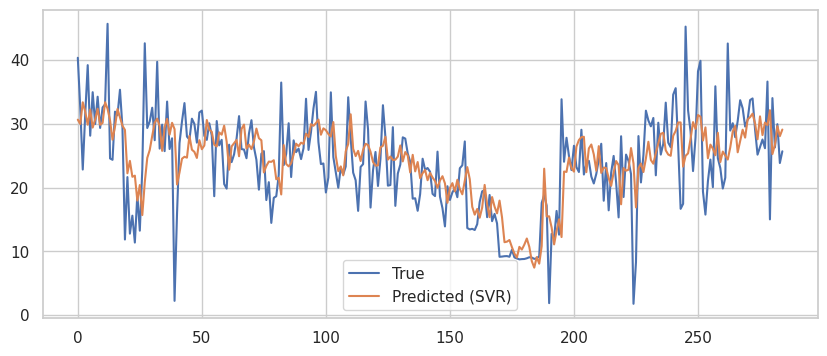


Done. Files saved: scaler_next_day.pkl, dl_model_*.h5, (and best_model_overall.pkl if traditional).


In [ ]:
# ============================
# Multi-model benchmark including LSTM / GRU / 1D-CNN
# Optimized for ~8GB RAM laptops (small nets, early stopping)
# Paste & run as one cell
# ============================

# OPTIONAL: uncomment to install packages if missing
# !pip install -q xgboost lightgbm tensorflow catboost holidays

import os, zipfile, time, warnings
from urllib.request import urlopen
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
sns.set(style='whitegrid')
warnings.filterwarnings('ignore')

# ----------------------------
# ML imports
# ----------------------------
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# catboost optional
try:
    from catboost import CatBoostRegressor
    CATBOOST_AVAILABLE = True
except Exception:
    CATBOOST_AVAILABLE = False

# Keras for DL
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

tf.random.set_seed(42)
np.random.seed(42)

# ----------------------------
# Utility funcs
# ----------------------------
def evaluate_regression(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {"MAE": float(mae), "RMSE": float(rmse), "R2": float(r2)}

# ----------------------------
# === Data download & prep (same as before)
# ----------------------------
zip_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip'
print("Downloading dataset...")
resp = urlopen(zip_url).read()
with open('household_power_consumption.zip','wb') as f:
    f.write(resp)
with zipfile.ZipFile('household_power_consumption.zip','r') as z:
    z.extractall()

raw = pd.read_csv('household_power_consumption.txt', sep=';', na_values=['?'], low_memory=False)
raw['datetime'] = pd.to_datetime(raw['Date'] + ' ' + raw['Time'], dayfirst=True, errors='coerce')
cols = ['Global_active_power','Global_reactive_power','Voltage','Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']
for c in cols:
    raw[c] = pd.to_numeric(raw[c], errors='coerce')
raw = raw.dropna(subset=['datetime']).sort_values('datetime').reset_index(drop=True).set_index('datetime')

hourly = raw[cols].resample('h').mean().dropna().reset_index()
hourly['date'] = hourly['datetime'].dt.date

daily = hourly.groupby('date').agg({
    'Global_active_power':'sum',
    'Global_reactive_power':'mean',
    'Voltage':'mean',
    'Global_intensity':'mean',
    'Sub_metering_1':'sum',
    'Sub_metering_2':'sum',
    'Sub_metering_3':'sum'
}).rename(columns={'Global_active_power':'daily_kwh'}).reset_index()

# features
daily['prev_day_kwh'] = daily['daily_kwh'].shift(1)
daily['rolling_7d_mean'] = daily['daily_kwh'].rolling(7).mean().shift(1)

# simple simulated weather (replace with API later)
np.random.seed(42)
daily['temperature'] = 25 + np.sin(np.arange(len(daily))/30)*10 + np.random.normal(0,2,len(daily))
daily['humidity'] = 60 + np.random.normal(0,5,len(daily))

# holiday/weekend
try:
    import holidays
    years = range(pd.to_datetime(daily['date']).dt.year.min(), pd.to_datetime(daily['date']).dt.year.max()+1)
    india_holidays = holidays.India(years=years)
    daily['is_holiday'] = daily['date'].apply(lambda d: 1 if d in india_holidays else 0)
except Exception:
    daily['is_holiday'] = 0
daily['is_weekend'] = pd.to_datetime(daily['date']).dt.dayofweek.isin([5,6]).astype(int)

daily['day_of_week'] = pd.to_datetime(daily['date']).dt.dayofweek
daily['target_next_day_kwh'] = daily['daily_kwh'].shift(-1)
daily = daily.dropna().reset_index(drop=True)

features = [
    'prev_day_kwh','rolling_7d_mean','Global_reactive_power','Voltage',
    'Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3',
    'day_of_week','temperature','humidity','is_holiday','is_weekend'
]
X = daily[features].copy()
y = daily['target_next_day_kwh'].copy()

# time-based split 80/20
split_idx = int(len(X)*0.8)
X_train, X_test = X.iloc[:split_idx].copy(), X.iloc[split_idx:].copy()
y_train, y_test = y.iloc[:split_idx].copy(), y.iloc[split_idx:].copy()

# scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, 'scaler_next_day.pkl')

print(f"Data ready — train samples: {len(X_train)}, test samples: {len(X_test)}")

# ----------------------------
# Traditional model zoo
# ----------------------------
USE_SCALED = {"LinearRegression","Ridge","Lasso","SVR","KNN","XGBoost","LightGBM","CatBoost"}

def get_traditional_models():
    models = {
        "LinearRegression": LinearRegression(),
        "Ridge": Ridge(alpha=1.0),
        "Lasso": Lasso(alpha=0.001),
        "KNN": KNeighborsRegressor(n_neighbors=5),
        "SVR": SVR(kernel='rbf', C=1.0, epsilon=0.1),
        "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
        "XGBoost": xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=42, verbosity=0),
        "LightGBM": lgb.LGBMRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
    }
    if CATBOOST_AVAILABLE:
        models["CatBoost"] = CatBoostRegressor(verbose=0, random_seed=42)
    return models

models = get_traditional_models()
results = []; trained_models = {}
print("\nRunning traditional & boosting models...")
t0_all = time.time()
for name, model in models.items():
    use_scaled = name in USE_SCALED
    Xtr = X_train_scaled if use_scaled else X_train
    Xtst = X_test_scaled if use_scaled else X_test
    t0 = time.time()
    try:
        model.fit(Xtr, y_train)
        preds = model.predict(Xtst)
        metrics = evaluate_regression(y_test, preds)
        metrics.update({"Model": name, "TrainTime_s": round(time.time()-t0,3)})
        results.append(metrics)
        trained_models[name] = model
        print(f"  → {name} done — RMSE: {metrics['RMSE']:.4f}")
    except Exception as e:
        print(f"  → {name} failed:", e)
print("Traditional models done in {:.1f}s".format(time.time()-t0_all))

results_df_trad = pd.DataFrame(results).sort_values('RMSE').reset_index(drop=True)
display(results_df_trad)

# ----------------------------
# Build sequences for DL from scaled X (use entire X order aligned with daily)
# ----------------------------
DL_WINDOW = 7        # 7-day window is a good starting point for daily forecasting
DL_EPOCHS = 20       # small for CPU-friendly runs
DL_BATCH = 32

X_for_seq = pd.DataFrame(scaler.transform(X), columns=X.columns)
y_for_seq = daily['target_next_day_kwh'].values

def create_sequences(X_df, y_arr, window=DL_WINDOW):
    X_arr = X_df.values
    n = len(X_arr) - window
    if n <= 0:
        raise ValueError("Not enough data for window. Reduce DL_WINDOW.")
    seq_X = np.zeros((n, window, X_arr.shape[1]))
    seq_y = np.zeros(n)
    for i in range(n):
        seq_X[i] = X_arr[i:i+window]
        seq_y[i] = y_arr[i+window]
    return seq_X, seq_y

X_seq, y_seq = create_sequences(X_for_seq, y_for_seq, window=DL_WINDOW)
split_idx_seq = int(len(X_seq)*0.8)
X_train_seq, X_test_seq = X_seq[:split_idx_seq], X_seq[split_idx_seq:]
y_train_seq, y_test_seq = y_seq[:split_idx_seq], y_seq[split_idx_seq:]
print(f"DL sequences shapes — train: {X_train_seq.shape}, test: {X_test_seq.shape}")

# ----------------------------
# Build lightweight DL models (small to run on CPU)
# ----------------------------
n_features = X_train_seq.shape[2]

def build_lstm(window, n_features):
    model = Sequential([
        LSTM(64, input_shape=(window, n_features)),
        Dropout(0.15),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def build_gru(window, n_features):
    model = Sequential([
        GRU(64, input_shape=(window, n_features)),
        Dropout(0.15),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def build_cnn(window, n_features):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(window, n_features)))
    model.add(BatchNormalization())
    model.add(Conv1D(32, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# instantiate models
dl_models = {
    "LSTM": build_lstm(DL_WINDOW, n_features),
    "GRU": build_gru(DL_WINDOW, n_features),
    "CNN": build_cnn(DL_WINDOW, n_features)
}

# callbacks
es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=0)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0)

# train & evaluate DL models (small epochs)
dl_results = []
for name, model in dl_models.items():
    print(f"\nTraining DL model: {name} (epochs={DL_EPOCHS}, batch={DL_BATCH}) ...")
    t0 = time.time()
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_test_seq, y_test_seq),
        epochs=DL_EPOCHS,
        batch_size=DL_BATCH,
        callbacks=[es, rlr],
        verbose=0
    )
    elapsed = time.time() - t0
    preds = model.predict(X_test_seq).ravel()
    metrics = evaluate_regression(y_test_seq, preds)
    metrics.update({"Model": name, "TrainTime_s": round(elapsed,2)})
    dl_results.append(metrics)
    print(f" -> {name} done — RMSE: {metrics['RMSE']:.4f}, MAE: {metrics['MAE']:.4f}")

dl_df = pd.DataFrame(dl_results).sort_values('RMSE').reset_index(drop=True)
display(dl_df)

# Save DL models to disk (small files)
for name, model in dl_models.items():
    model.save(f"dl_model_{name}.h5")
    print("Saved:", f"dl_model_{name}.h5")

# ----------------------------
# Combine leaderboards and pick overall best
# ----------------------------
combined = pd.concat([results_df_trad, dl_df], ignore_index=True, sort=False).sort_values('RMSE').reset_index(drop=True)
print("\nCombined leaderboard (sorted by RMSE):")
display(combined)

best = combined.iloc[0]
best_name = best['Model']
print(f"\nBest overall model: {best_name}  RMSE={best['RMSE']:.4f}, MAE={best['MAE']:.4f}")

# Save best model (traditional via joblib; DL via keras.save already done)
if best_name in trained_models:
    joblib.dump(trained_models[best_name], 'best_model_overall.pkl')
    print("Saved best traditional model as best_model_overall.pkl")
elif best_name in dl_models:
    # already saved above as dl_model_{name}.h5
    print(f"Best model is a DL model — saved as dl_model_{best_name}.h5")

# Quick plot: true vs predicted for best model
print("\nPlot: True vs Predicted for best model")
plt.figure(figsize=(10,4))
if best_name in trained_models:
    m = trained_models[best_name]
    preds = m.predict(X_test_scaled if best_name in USE_SCALED else X_test)
    plt.plot(y_test.values, label='True')
    plt.plot(preds, label=f'Predicted ({best_name})')
else:
    m = dl_models[best_name]
    preds = m.predict(X_test_seq).ravel()
    plt.plot(y_test_seq, label='True (seq)')
    plt.plot(preds, label=f'Predicted ({best_name})')
plt.legend()
plt.show()

print("\nDone. Files saved: scaler_next_day.pkl, dl_model_*.h5, (and best_model_overall.pkl if traditional).")
